In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

**First**, low-level tensor manipulation — the infrastructure that underlies all modern machine learning. This translates to TensorFlow APIs:

**Tensors**, including special tensors that store the network’s state (variables)

**Tensor operations** such as addition, relu, matmul

**Backpropagation**, a way to compute the gradient of mathematical expressions (handled in TensorFlow via the GradientTape object)

**Second**, high-level deep learning concepts. This translates to Keras APIs:

**Layers**, which are combined into a model

**A loss function**, which defines the feedback signal used for learning

**An optimizer**, which determines how learning proceeds

**Metrics** to evaluate model performance, such as accuracy

**A training loop** that performs mini-batch stochastic gradient descent

### Constant tensors and Variables

Tensors need to be created with some initial value, so common ways to create tensors are:

In [19]:

x = tf.ones(shape=(2, 1)) # equivalent to np.ones(shape=(2, 1))
print(x)
x = tf.zeros(shape=(2, 1))  # # equivalent to np.zeros(shape=(2, 1))
print(x)


tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


In [21]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)  # tensor of random values drawn from normal distribution with mean 0 and std deviation 1, equivalent to np.random.normal(size=(3, 1), loc=0, scale=1)
print(x)

tf.Tensor(
[[ 0.6002201]
 [-0.5588277]
 [-0.6974723]], shape=(3, 1), dtype=float32)


In [22]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.) # tensor of random values drawn from a uniform distribution between 0 and 1, equivalent to np.random.uniform(size=(3, 1), low=0, high=1)
print(x)

tf.Tensor(
[[0.6912353]
 [0.1240232]
 [0.6356293]], shape=(3, 1), dtype=float32)


A significant difference between NumPy arrays and TensorFlow tensors is that TensorFlow tensors aren’t assignable: they’re constant. For instance, in NumPy, you can do:

In [26]:
x = np.ones(shape=(2, 2))
x[0, 0] = 0
x

array([[0., 1.],
       [1., 1.]])

in TensorFlow there is an error, "EagerTensor object does not support item assignment".

In [28]:
x = tf.ones(shape=(2, 2))
x[0, 0] = 0

TypeError: ignored

To train a model, we’ll need to update its state, which is a set of tensors. If tensors aren’t assignable, how do we do it, then? That’s where variables come in. tf.Variable is the class meant to manage modifiable state in TensorFlow. 

In [29]:
v = tf.Variable(initial_value=tf.ones(shape=(2, 2)))
print(v)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>


The state of a variable can be modified via its assign method:

In [31]:
v.assign(tf.zeros((2, 2)))

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

It also works for a subset of the coefficients:

In [32]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[3., 0.],
       [0., 0.]], dtype=float32)>

Similarly, assign_add and assign_sub are efficient equivalents of += and -=:

In [35]:
v.assign_add(tf.ones(shape=(2, 2)))

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[4., 1.],
       [1., 1.]], dtype=float32)>

In [38]:
v.assign_sub(tf.ones(shape=(2, 2)))

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[3., 0.],
       [0., 0.]], dtype=float32)>

### Tensor operations: doing math in TensorFlow

Just like NumPy, TensorFlow offers a large collection of tensor operations to express mathematical formulas.

In [47]:
a = tf.ones((2, 2))

b = tf.square(a)  # take a square
print(b)
c = tf.sqrt(a)  # take a square root
print(c)
d = b + c # add two tensors (element-wise)
print(d)
e = tf.matmul(a, b)  # take the product of two tensors
print(e)
e *= d  # multiply two  tensors (element-wise)
print(e)

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[2. 2.]
 [2. 2.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[4. 4.]
 [4. 4.]], shape=(2, 2), dtype=float32)


### Look at the GradientTape API

So far, TensorFlow seems to look a lot like NumPy. But here’s something NumPy can’t do: retrieve the gradient of any differentiable expression with respect to any of its inputs. Just open a GradientTape scope, apply some computation to one or several input tensors, and retrieve the gradient of the result with respect to the inputs.

This is most commonly used to retrieve the gradients of the weights of a model with respect to its loss: gradients = tape.gradient(loss, weights)

In [52]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
print(result)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


So far, you’ve only seen the case where the input tensors in tape.gradient() were TensorFlow variables. It’s actually possible for these inputs to be any arbitrary tensor. However, only trainable variables are being tracked by default. With a constant tensor, you’d have to manually mark it as being tracked, by calling tape.watch() on it:

In [59]:
# Using the GradientTape with constant tensor inputs
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


The gradient tape is a powerful utility, even capable of computing second-order gradients, that is to say, the gradient of a gradient. For instance, the gradient of the position of an object with regard to time is the speed of that object, and the second-order gradient is its acceleration.

If you measure the position of a falling apple along a vertical axis over time, and find that it verifies $$position(time) = 4.9 * time ** 2$$, what is its acceleration? Let’s use two nested gradient tapes to find out.

In [63]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
  print(speed)
acceleration = outer_tape.gradient(speed, time)
print(acceleration)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(9.8, shape=(), dtype=float32)


### An end-to-end example: a linear classifier in pure TensorFlow

Knowing about tensors, variables, tensor operations and how to compute gradients. That’s enough to build any machine learning model based on gradient descent.

In a machine learning job interview, you may be asked to implement a linear classifier from scratch in TensorFlow: a very simple task that serves as a filter between candidates who have some minimal machine learning background, and those who don’t. Let’s get you past that filter, and use your newfound knowledge of TensorFlow to implement such a linear classifier.

#### First, let’s come up with some nicely linearly-separable synthetic data to work with: two classes of points in a 2D plane.

In [66]:
num_samples_per_class = 1000
# generate first class of points - 1000 random 2D points with specified "mean" and "covariance matrix"
# intuitively, the "covariance matrix" describes the shape of the point cloud and the "mean" describes its position in the plane
# cov=[[1, 0.5], [0.5, 1]] corresponds to "oval-like point cloud oriented from bottom left to top right"
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)
# generate the other class of points with a difference mean and the same covariance matrix (point cloud with a different position and the same shape).
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)

negative_samples and positive_samples are both arrays with shape (1000, 2). Let’s stack them into a single array with shape (2000, 2):

In [68]:
# stacking the two classes into an array with shape (2000, 2)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

Let’s generate the corresponding target labels, an array of zeros and ones of shape (2000, 1), where targets[i, 0] is 0 if inputs[i] belongs to class 0 (and inversely):

In [70]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"), np.ones((num_samples_per_class, 1), dtype="float32")))

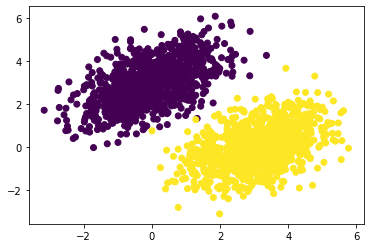

In [71]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

Now, let’s create a linear classifier that can learn to separate these two blobs. A linear classifier is an affine transformation $$prediction = W • input + b$$ trained to minimize the square of the difference between predictions and the targets.

Let’s create our variables W and b, initialized with random values and with zeros respectively:

In [74]:
# The inputs will be 2D points.
input_dim = 2
# The output predictions will be a single score per sample (close to 0 if the sample is predicted to be in class 0, and close to 1 if the sample is predicted to be in class 1).
output_dim = 1

W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

Here’s our forward pass function:

In [75]:
def model(inputs):
  return tf.matmul(inputs, W) + b

Because our linear classifier operates on 2D inputs, W is really just two scalar coefficients, w1 and w2: W = [[w1], [w2]]. Meanwhile, b is a single scalar coefficient. As such, for given input point [x, y], its prediction value is: $$prediction = [[w1], [w2]] • [x, y] + b = w1 * x + w2 * y + b$$

Here’s our loss function:

In [76]:
# The mean squared error loss function
def square_loss(targets, prediction):
  per_sample_loses = tf.square(targets - prediction)
  return tf.reduce_mean(per_sample_loses)

Now, the training step, which receives some training data and updates the weights W and b so as to minimize the loss on the data:

In [80]:
# The training step function
learning_rate = 0.1

def training_step(inputs, targets):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(targets, predictions)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)
  
  return loss  

For simplicity, we’ll do batch training instead of mini-batch training: we’ll run each training step (gradient computation and weight update) on the entire data, rather than iterate over the data in small batches. On one hand, this means that each training step will take much longer to run, since we compute the forward pass and the gradients for 2,000 samples at once. One the other hand, each gradient update will be much more effective at reducing the loss on the training data, since it will encompass information from all training samples instead of, say, only 128 random samples. As a result, we will need much fewer steps of training, and we should use a larger learning rate than what we would typically use for mini-batch training (we’ll use learning_rate = 0.1)

In [82]:
for step in range(30):
  loss = training_step(inputs, targets)
  print(f"Loss at step {step}: {loss}")

Loss at step 0: 0.04518289491534233
Loss at step 1: 0.04351012781262398
Loss at step 2: 0.041974976658821106
Loss at step 3: 0.04056612029671669
Loss at step 4: 0.039273157715797424
Loss at step 5: 0.03808657079935074
Loss at step 6: 0.03699759393930435
Loss at step 7: 0.035998206585645676
Loss at step 8: 0.035081036388874054
Loss at step 9: 0.03423931449651718
Loss at step 10: 0.03346683830022812
Loss at step 11: 0.03275791555643082
Loss at step 12: 0.03210730850696564
Loss at step 13: 0.03151023015379906
Loss at step 14: 0.03096226416528225
Loss at step 15: 0.030459383502602577
Loss at step 16: 0.029997868463397026
Loss at step 17: 0.0295743215829134
Loss at step 18: 0.029185619205236435
Loss at step 19: 0.028828894719481468
Loss at step 20: 0.028501514345407486
Loss at step 21: 0.028201067820191383
Loss at step 22: 0.027925336733460426
Loss at step 23: 0.02767229452729225
Loss at step 24: 0.027440063655376434
Loss at step 25: 0.02722693607211113
Loss at step 26: 0.027031349018216133

Let’s plot how our linear model classifies the training data points. Because our targets are zeros and ones, a given input point will be classified as "0" if its prediction value is below 0.5, and as "1" if it is above 0.5:

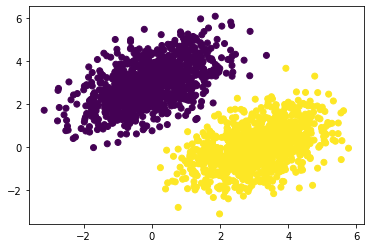

In [84]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

Recall that the prediction value for a given point [x, y] is simply $$prediction == [[w1], [w2]] • [x, y] + b == w1 * x + w2 * y + b$$ Thus, class "0" is defined as: $$w1 * x + w2 * y + b < 0.5$$ and class "1" is defined as: $$w1 * x + w2 * y + b > 0.5$$ You’ll notice that what you’re looking at is really the equation of a line in the 2D plane: $$w1 * x + w2 * y + b = 0.5$$ Above the line, class 1, below the line, class 0. You may be used to seeing line equations in the format $$y = a * x + b$$ in the same format, our line becomes: $$y = - w1 / w2 * x + (0.5 - b) / w2$$

Let’s plot this line:

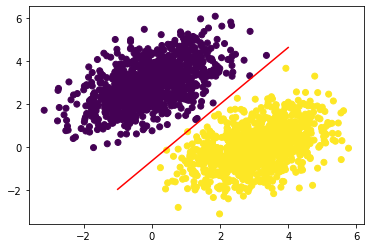

In [86]:
# Generate 100 regularly spaced numbers between -1 and 4, which we will use to plot our line
x = np.linspace(-1, 4, 100)
# This is the line’s equation
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
# Plot our line ('-r' means "plot it as a red line")
plt.plot(x, y, '-r')
# Plot our model’s predictions on the same plot
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()